# Regressions
We'll start by creating a function which performs a linear regression on each data set.

In [1]:
import math

from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.python.data import Dataset
tf.logging.set_verbosity(tf.logging.ERROR) # Gets TensorFlow to shut the fuck up

# from QWK import quadratic_weighted_kappa   # Upload the QWK.py file
# from sklearn.metrics import cohen_kappa_score

# Import Pre-processed Data
training_set = pd.read_pickle('preprocessedTrainingNoEssay.pkl')
training_set.sample(5)

,essay_id,topic,target_score,ner,word_count,token_count,unique_token_count,nostop_count,sent_count,ner_unredacted_count,dw_ratio,h_similarity,sw_ratio,ners_ratio,TTR,flesch,smog,kincaid,coleman_liau,readability,dale_chall,difficult_words,linsear,gunning_fog,grade_level,comma,question,exclamation,quotation,noun,adj,pron,verb,cconj,adv,det,propn,num,part,intj
7577,12325,5,1,5,299,61,41,30,4,4,0.030100,0.970363,74.750000,1.250000,0.672131,74.39,8.1,6.3,7.24,6.4,6.90,9,6.625000,7.70,6th and 7th grade,0,0,0,2,12,3,2,12,0,1,10,3,1,3,0
10273,16223,6,3,4,636,111,73,54,6,4,0.042453,0.974133,106.000000,0.666667,0.657658,46.10,13.8,13.0,13.47,16.3,9.14,27,16.000000,14.00,13th and 14th grade,4,0,0,1,30,5,1,14,2,6,21,4,0,1,0
492,495,1,8,15,1739,355,168,151,26,12,0.021852,0.988348,66.884615,0.576923,0.473239,73.68,10.1,6.6,8.29,8.0,6.32,38,12.400000,7.77,7th and 8th grade,20,1,0,6,72,30,13,66,14,29,30,5,2,9,0
2256,3451,2,4,6,1763,355,162,139,19,5,0.017016,0.977813,92.789474,0.315789,0.456338,68.50,9.8,8.6,8.47,9.9,6.12,30,7.142857,9.37,8th and 9th grade,14,1,0,2,78,21,21,64,6,24,48,0,3,8,0
9226,15176,6,4,7,1412,259,134,110,11,7,0.026204,0.989781,128.363636,0.636364,0.517375,58.11,12.9,10.5,11.08,12.8,7.18,37,13.200000,11.31,12th and 13th grade,10,0,0,0,58,9,6,57,6,11,38,9,5,10,0


In [0]:
# TensorFlow 2.0
!pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

In [0]:
topics = [1,2,3,4,5,6,7,8]  # Add or remove topics at your leisure

predictors = [              # Deatures we'll be using
    "word_count",
    "TTR",
    "readability",
    "unique_token_count",
    "ner",
    "sw_ratio",
    "ners_ratio"] 

# TensorFlow 1.0

## Declaring TF Functions
* **featurePrep** - Extracts features from `training_set` into a seperate Pandas table
* **targetPrep** - Extracts targets from `training_set` into a seperate Pandas table
* **featureColumns** - Creates feature columns in TensorFlow
* **my_input_fn** - I have no idea what this does but it makes the whole thing work



In [0]:
def preprocess_features(training_set):
  selected_features = training_set[predictors]
  return selected_features.copy()

def preprocess_targets(training_set):
  output_targets = pd.DataFrame()
  output_targets["target_score"] = training_set["target_score"]
  return output_targets

def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])
  
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):  
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

## Overfitting Prevention

![overfitting](https://raw.githubusercontent.com/BobCrables/ComparisonAES/master/overfitting.jpg)

## LinearRegressor

### Declaration

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model, prints training progress information 
  and plots of the training and validation loss.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `training_set` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `training_set` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `training_set` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `training_set` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["target_score"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["target_score"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["target_score"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))

    # Print the QWK Score
    # trainingQWK = quadratic_weighted_kappa(training_predictions, training_targets, int(training_predictions.min()), int(training_predictions.max()))
    # print("  period (QWK) %02d : %0.2f" % (period, trainingQWK))

    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor, validation_predictions

### Training

I've put the hyperparameters within the loop because I'm here to standardize them across topics.

Training model #01
RMSE (on training data):
  period 00 : 7.77
  period 01 : 7.36
  period 02 : 7.04
  period 03 : 6.77
  period 04 : 6.53
  period 05 : 6.32
  period 06 : 6.13
  period 07 : 5.94
  period 08 : 5.77
  period 09 : 5.61
Model training finished.
Training model #02
RMSE (on training data):
  period 00 : 2.58
  period 01 : 2.17
  period 02 : 1.86
  period 03 : 1.61
  period 04 : 1.41
  period 05 : 1.24
  period 06 : 1.11
  period 07 : 1.02
  period 08 : 0.95
  period 09 : 0.92
Model training finished.
Training model #03
RMSE (on training data):
  period 00 : 1.72
  period 01 : 1.59
  period 02 : 1.49
  period 03 : 1.40
  period 04 : 1.33
  period 05 : 1.27
  period 06 : 1.21
  period 07 : 1.15
  period 08 : 1.10
  period 09 : 1.06
Model training finished.
Training model #04
RMSE (on training data):
  period 00 : 1.45
  period 01 : 1.34
  period 02 : 1.25
  period 03 : 1.18
  period 04 : 1.11
  period 05 : 1.06
  period 06 : 1.01
  period 07 : 0.96
  period 08 : 0.92
  period

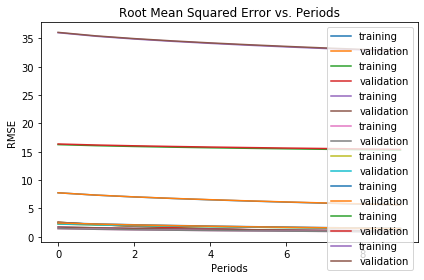

In [0]:
tempSet = []

for x in topics:
  print("Training model #%02d" % (x))
  tempSet = training_set.loc[training_set['topic'] == x]
  top = round(len(tempSet.index) * 0.7)
  btm = round(len(tempSet.index) * 0.3)
  training_examples = preprocess_features(tempSet.head(top))
  training_targets = preprocess_targets(tempSet.head(top))
  validation_examples = preprocess_features(tempSet.tail(btm))
  validation_targets = preprocess_targets(tempSet.tail(btm))
  linear_regressor = train_model(
      learning_rate=1,          # defaults: 1   .00003
      steps=500,                #           500 500
      batch_size=100,           #           100 10
      feature_columns=construct_feature_columns(training_examples),
      training_examples=training_examples,
      training_targets=training_targets,
      validation_examples=validation_examples,
      validation_targets=validation_targets
      )